### **Imports Made**:
- Numpy for general purpose tasks (ex: file loads, matrix operations and arrangements, etc)
- sklearn.linear_model for the multiple models tested
- sklearn.mixture for Gaussian Mixture Model
- data_spliter for splitting the data into training and testing sets
- matplotlib.pyplot for plotting the data

In [1]:
import numpy as np
from sklearn.linear_model import RANSACRegressor,LinearRegression,Ridge
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from itertools import combinations

### **Data Spliter**:

Function that splits the data into training and testing sets. Returns all possible training and test sets.

In [2]:
def split_data(x, y, number):
    index_combinations = list(combinations(range(len(x)), number))

    x_test = []
    x_train = []
    y_test = []
    y_train = []

    for indices in index_combinations:
        
        x_test.append(np.array([x[i] for i in indices]))
        x_train.append(np.array([x[i] for i in range(len(x)) if i not in indices]))

        y_test.append(np.array([y[i] for i in indices]))
        y_train.append(np.array([y[i] for i in range(len(y)) if i not in indices]))

    return x_test, x_train, y_test, y_train

### **Data Extraction**:

Input files are loaded into variables *x*, *y* and *x_project*, this last one being from the *x_test* file.

In [3]:
x = np.load("X_train_regression2.npy")
y = np.load("y_train_regression2.npy")
x_project = np.load("X_test_regression2.npy")

### **RANSAC**:

In our earlier implementations we utilized the **RANSAC** function as shown below to classify the data. The function takes the data as input and attempts to fit a cylinder with a radius based on the median absolute deviation. The function returns the inliers and the outliers of the data. Using this method we can separate the two models expect in the interception.

In [4]:
ransac = RANSACRegressor(estimator=LinearRegression(),random_state=1)  

ransac.fit(x, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

Model1_x = x[inlier_mask]
Model1_y = y[inlier_mask]

Model2_x = x[outlier_mask]
Model2_y = y[outlier_mask]


### **Cross-Validation and SSE Calculation (Model 1)**:

We utilize cross-validation leave one out to provide us a metric from which to compare models and hyper-parameter tuning, which the function split_data provides the list of all possible combinations of size *subset_size*. By separating our original training data (*Model1_x* and *Model1_y*) into two subsets of *x_train*/*y_train* and *x_test*/*y_test*. At the end of all these possible arrangement combinations the SSE mean is calculated and displayed.

Best alpha:  0.18100000000000008
Best SSE:  0.08138965626665125


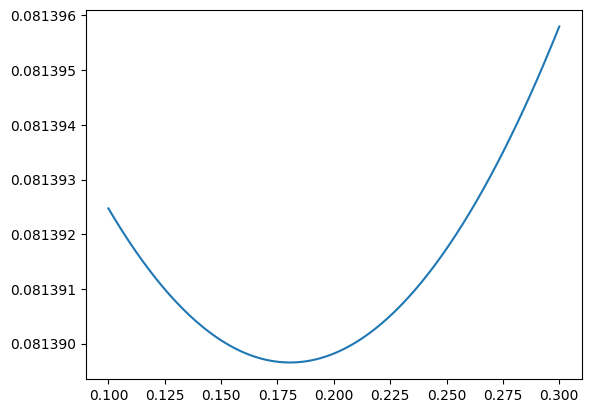

In [5]:
# Model 1
best_alpha = 0
hist_sse = 1000
subset_sizes = [1]

# Alphas values
start = 0.1
end = 0.3
step = 0.001
alphas = np.arange(start, end + step, step)
sse = []

for subset_size in subset_sizes:
    x_test, x_train, y_test, y_train = split_data(Model1_x, Model1_y, subset_size)

    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        
        values = []
        
        for i in range(len(x_train)):
            ridge.fit(x_train[i], y_train[i])
            y_pred = ridge.predict(x_test[i])
            values.append(sum((y_test[i] - y_pred)**2)[0]/subset_size)
            
        sse.append(sum(values)/len(values))    
        if hist_sse > sum(values)/len(values):
            best_alpha = alpha
            hist_sse = sum(values)/len(values)


print("Best alpha: ", best_alpha)
print("Best SSE: ", hist_sse)
plt.plot(alphas, sse)

### **SSE Effect per point (Model 1)**:

In the previous section, we determined alpha. Now, we can find the Sum of Squared Errors for each individual data point. 

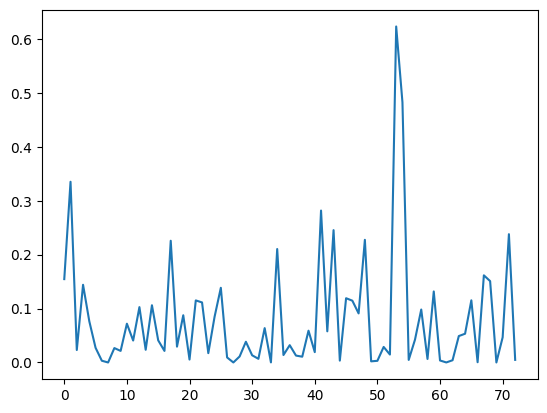

In [6]:
sse = []
for subset_size in subset_sizes:
    x_test, x_train, y_test, y_train = split_data(Model1_x, Model1_y, subset_size)
    ridge = Ridge(alpha=0.180568)
    
    for i in range(len(x_train)):
        ridge.fit(x_train[i], y_train[i])
        y_pred = ridge.predict(x_test[i])
        sse.append(sum((y_test[i] - y_pred)**2)[0]/subset_size)

plt.plot(range(len(sse)), sse)

### **Cross-Validation, SSE Calculation and SSE Effect per point (Model 2)**:

As said previewsly, we will be using cross validation leave one out to provide us a metric from which to compare models and hyper-parameter tuning, which the function split_data provides the list of all possible combinations of size *subset_size*. 

SSE:  0.03661800871987473


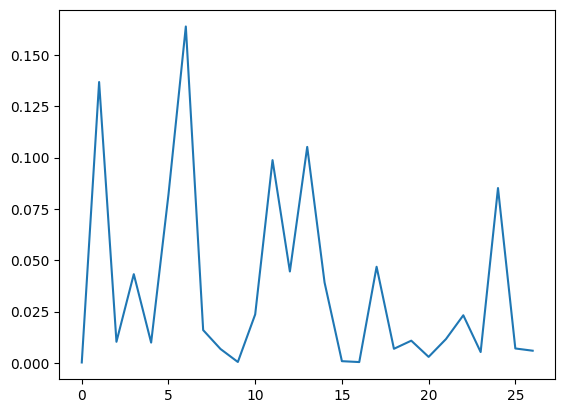

In [7]:
# Model 2
subset_sizes = [1]

for subset_size in subset_sizes:
    x_test, x_train, y_test, y_train = split_data(Model2_x, Model2_y, subset_size)

    model = LinearRegression()
    
    values = []
    for i in range(len(x_train)):
        model.fit(x_train[i], y_train[i])
        y_pred = model.predict(x_test[i])
        values.append(sum((y_test[i] - y_pred)**2)[0]/subset_size)
        

plt.plot(range(len(values)),values)
print("SSE: ",sum(values)/len(values))     

### **Plot Generation (RANSAC)**:

Here we plot the data and the models generated by the RANSAC function. Model 1, represented by the blue line, and Model 2, represented by the green line. 

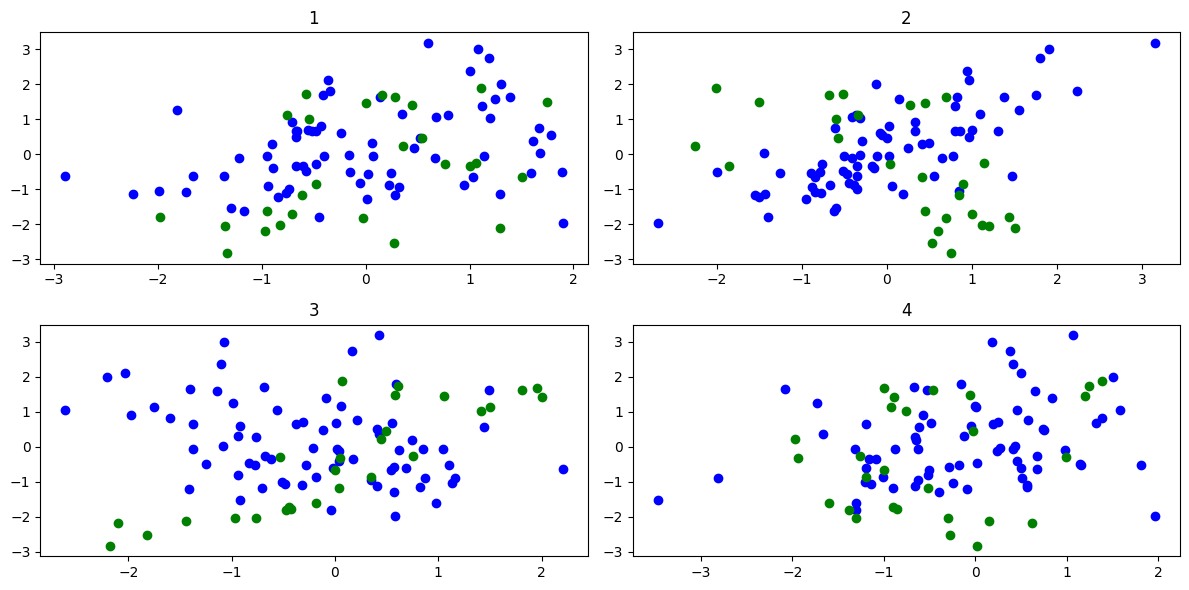

In [8]:
# Plot data
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot data on each subplot
axs[0, 0].scatter(Model1_x[:, 0], Model1_y, color='blue', label='Model1')
axs[0, 0].scatter(Model2_x[:, 0], Model2_y , color='green', label='Model2')
axs[0, 0].set_title('1')

axs[0, 1].scatter(Model1_x[:, 1], Model1_y, color='blue', label='Model1')
axs[0, 1].scatter(Model2_x[:, 1], Model2_y, color='green', label='Model2')
axs[0, 1].set_title('2')

axs[1, 0].scatter(Model1_x[:, 2], Model1_y, color='blue', label='Model1')
axs[1, 0].scatter(Model2_x[:, 2], Model2_y, color='green', label='Model2')
axs[1, 0].set_title('3')

axs[1, 1].scatter(Model1_x[:, 3], Model1_y, color='blue', label='Model1')
axs[1, 1].scatter(Model2_x[:, 3], Model2_y, color='green', label='Model2')

axs[1, 1].set_title('4')


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

### **Gaussian Mixture**:

After extensive testing of multiple models, we determined that this particular model stood out as the best choice. Its effectiveness lies in its ability to analyze the data's distribution and predict the probability of a point belonging to a specific distribution, thus eliminating the issue of interception.

In [9]:
data = np.concatenate((x, y), axis=1)

gmm = GaussianMixture(n_components=2)
gmm.fit(data)
labels = gmm.predict(data)

Model1_x = x[labels == 0]
Model1_y = y[labels == 0]
Model2_x = x[labels == 1]
Model2_y = y[labels == 1]

# In case GaussianMixture splits data in the wrong way
if Model1_x.shape[0] < Model2_x.shape[0]:
    temp = Model1_x
    Model1_x = Model2_x
    Model2_x = temp
    temp = Model1_y
    Model1_y = Model2_y
    Model2_y = temp

# Delete Outliers
Model1_x = np.delete(Model1_x, [19,38,43], axis=0)
Model1_y = np.delete(Model1_y, [19,38,43], axis=0)

### **Cross-Validation and SSE Calculation (Model 1)**:

Best alpha:  0.18400000000000008
Best SSE:  0.03614344076060842


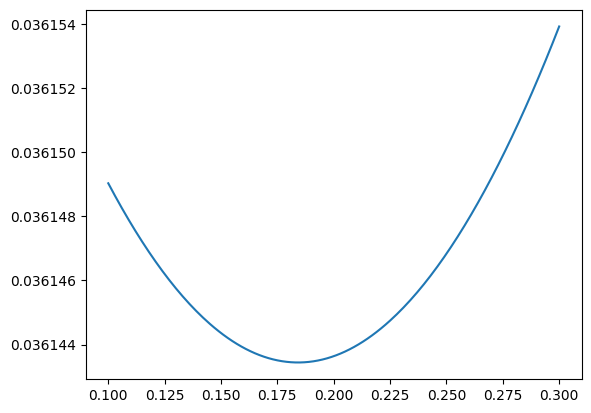

In [10]:
# Model 1

best_alpha = 0
hist_sse = 1000
subset_sizes = [1]

# Alphas values
start = 0.1
end = 0.3
step = 0.001
alphas = np.arange(start, end + step, step)
sse = []

for subset_size in subset_sizes:
    x_test, x_train, y_test, y_train = split_data(Model1_x, Model1_y, subset_size)

    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        
        values = []
        
        for i in range(len(x_train)):
            ridge.fit(x_train[i], y_train[i])
            y_pred = ridge.predict(x_test[i])
            values.append(sum((y_test[i] - y_pred)**2)[0]/subset_size)
            
        sse.append(sum(values)/len(values))    
        if hist_sse > sum(values)/len(values):
            best_alpha = alpha
            hist_sse = sum(values)/len(values)


print("Best alpha: ", best_alpha)
print("Best SSE: ", hist_sse)

plt.plot(alphas, sse)

### **SSE Effect per point (Model 1)**:

SSE:  0.0361434407340808


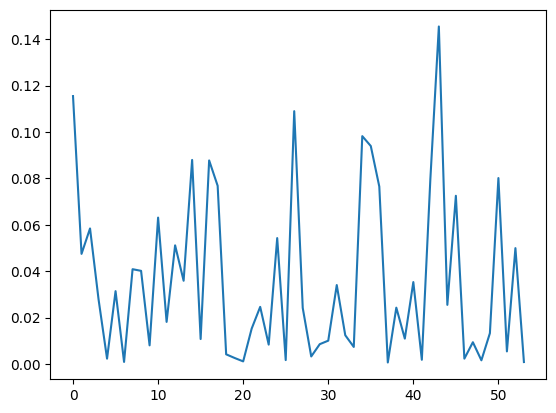

In [11]:
sse = []
for subset_size in subset_sizes:
    x_test, x_train, y_test, y_train = split_data(Model1_x, Model1_y, subset_size)
    ridge = Ridge(alpha=0.184184)
    
    for i in range(len(x_train)):
        ridge.fit(x_train[i], y_train[i])
        y_pred = ridge.predict(x_test[i])
        sse.append(sum((y_test[i] - y_pred)**2)[0]/subset_size)

print("SSE: ",sum(sse)/len(sse))
plt.plot(range(len(sse)), sse)     

### **Cross-Validation, SSE Calculation and SSE Effect per point (Model 2)**:

SSE:  0.037996251521764335


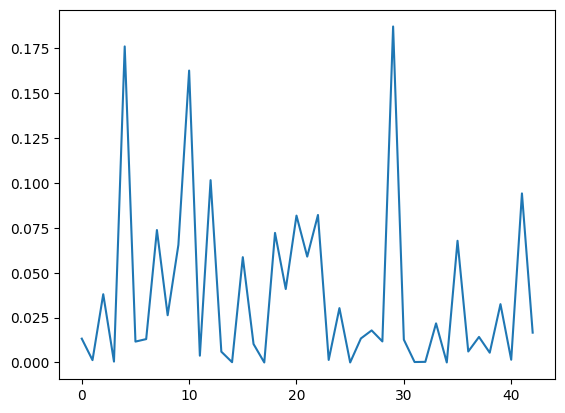

In [12]:
# Model 2
subset_sizes = [1]

for subset_size in subset_sizes:
    x_test, x_train, y_test, y_train = split_data(Model2_x, Model2_y, subset_size)

    model = LinearRegression()
    
    values = []
    for i in range(len(x_train)):
        model.fit(x_train[i], y_train[i])
        y_pred = model.predict(x_test[i])
        values.append(sum((y_test[i] - y_pred)**2)[0]/subset_size)
        

plt.plot(range(len(values)),values)
print("SSE: ",sum(values)/len(values))

### **Plot Generation (Gaussian Mixture)**:

Model 1, represented by the blue line, and Model 2, represented by the green line.

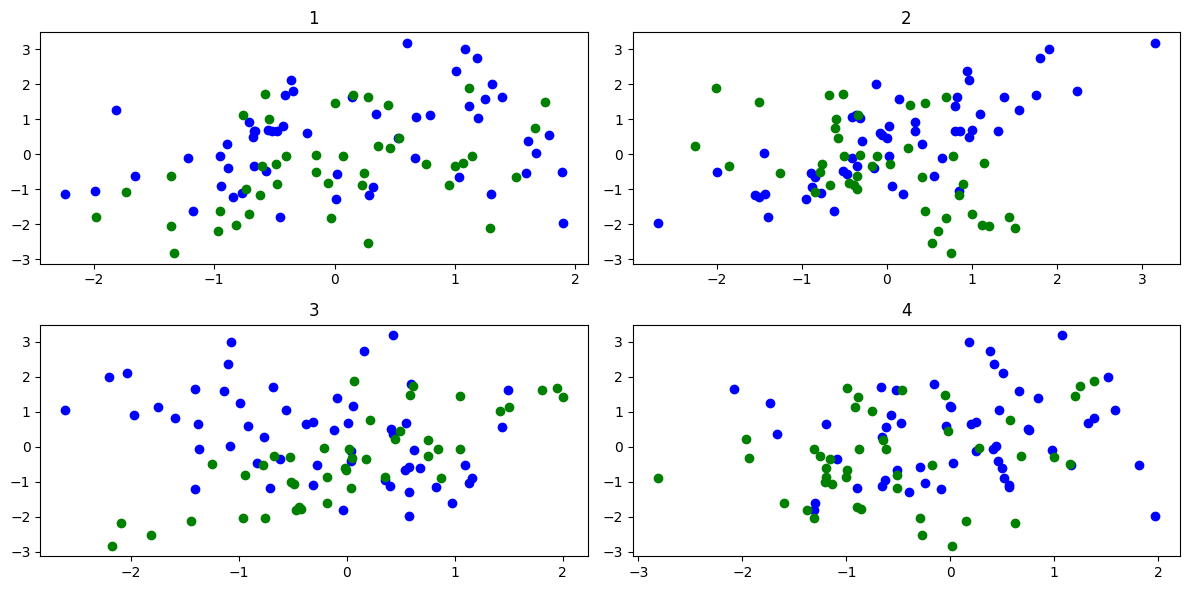

In [13]:
# Plot data
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot data on each subplot
axs[0, 0].scatter(Model1_x[:, 0], Model1_y, color='blue', label='Model1')
axs[0, 0].scatter(Model2_x[:, 0], Model2_y , color='green', label='Model2')
axs[0, 0].set_title('1')

axs[0, 1].scatter(Model1_x[:, 1], Model1_y, color='blue', label='Model1')
axs[0, 1].scatter(Model2_x[:, 1], Model2_y, color='green', label='Model2')
axs[0, 1].set_title('2')

axs[1, 0].scatter(Model1_x[:, 2], Model1_y, color='blue', label='Model1')
axs[1, 0].scatter(Model2_x[:, 2], Model2_y, color='green', label='Model2')
axs[1, 0].set_title('3')

axs[1, 1].scatter(Model1_x[:, 3], Model1_y, color='blue', label='Model1')
axs[1, 1].scatter(Model2_x[:, 3], Model2_y, color='green', label='Model2')

axs[1, 1].set_title('4')


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

Verify Shape

In [14]:
# Check Sizes
print(Model1_x.shape)
print(Model2_x.shape)

(54, 4)
(43, 4)


Resulting Points from the Models

In [15]:
# Model 1
ridge = Ridge(alpha=0.228333)
ridge.fit(Model1_x, Model1_y)
print(ridge.coef_)

# Model 2
linear_regression = LinearRegression()
linear_regression.fit(Model2_x, Model2_y)
print(linear_regression.coef_)

result = np.concatenate((ridge.predict(x_project), linear_regression.predict(x_project)), axis=1)

print(result.shape)
print(result)

np.save("y_test_regression2", result)

[[ 0.57351562  1.01442802 -0.4971325   0.0279309 ]]
[[ 0.06410582 -0.44974385  1.0704833   0.60024893]]
(1000, 2)
[[ 1.23611266 -0.06494668]
 [-1.08274669  0.10446085]
 [ 1.98739987 -1.46364994]
 ...
 [-1.83232587  1.34760052]
 [ 1.31078949  0.10659904]
 [-1.54576741  1.46040255]]
